# Phase 2
Indian Languages to English translation

## Libraries

In [10]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch import Tensor
from torch.utils.data import RandomSampler

import os
import math
import json
import csv
import gc
from time import strptime, localtime, strftime
from tqdm import tqdm
import logging
from datetime import datetime

from tokenizers import Tokenizer, SentencePieceBPETokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

from torch.utils.tensorboard import SummaryWriter

## Settings

In [48]:
MAX_LENGTH = 20

EMBEDDING_DIM = 128
ENCODER_HIDDEN_SIZE = 512
DECODER_HIDDEN_SIZE = 512

ENCODER_NUM_LAYERS = 1
DECODER_NUM_LAYERS = 2
N_ATTENTION_HEADS = 16

MAX_VOCAB = 32_000

SOURCE_VOCAB = 60_000
TARGET_VOCAB = 10_000

TRAIN_BATCH_SIZE = 10
VAL_BATCH_SIZE = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option('mode.chained_assignment',None)
os.environ['PYTORCH_NO_CUDA_MEMORY_CACHING'] = "0"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:100"

logging.basicConfig(filename='taurus.log', filemode='w+')

##### Directories and experiment setup
`experiment_id`: denotes the experiment ID in tensorboard image and the directory in which the data and model is saved

In [12]:
project_dir = 'answers'
# project_dir = '/content/drive/MyDrive/MT Competition/answers'

time_val = strptime("26-10-23 16_00", "%d-%m-%y %H_%M")

experiment_id = 'transformer_e1_d2_h16_sp_batch_128x1_new_vocab_exp_2'
print('Experiment ID:', experiment_id)

import os
dir_path = os.path.join('answers', experiment_id)
if not(os.path.exists(dir_path)):
    os.makedirs(dir_path)

model_filepath = os.path.join('answers',experiment_id,f'TRF.pkl')
answer_filepath = os.path.join('answers',experiment_id,f'answer.csv')
writer = SummaryWriter(os.path.join(project_dir, 'transformer_logs', experiment_id), comment=strftime("%d-%m-%y %H_%M", time_val))

Experiment ID: transformer_e1_d2_h16_sp_batch_128x1_new_vocab_exp_2


## Dataloader

##### Read the json files and convert to DataFrame

In [13]:
# Convert json data files to DataFrames

def convert_json_to_df(filepath) -> DataFrame:
    with open(filepath, 'r', encoding='utf-8') as f:
        data = pd.read_json(f)

    languages = data.columns

    all_data = []
    for lang in tqdm(languages, ncols=100, desc="Loading data"):
        new_frame = DataFrame(data.iloc[0][lang]).T
        new_frame['language'] = lang
        all_data.append(new_frame)
    
    all_data = pd.concat(all_data)
    return all_data

data = convert_json_to_df('train_data2.json').dropna().reset_index(names=['id'])
data['source_len'] = data['source'].apply(lambda x: len(x.split(' ')))
data['target_len'] = data['target'].apply(lambda x: len(x.split(' ')))


val_data = convert_json_to_df('val_data2.json').fillna('').reset_index(names=['id'])
val_data['source_len'] = val_data['source'].apply(lambda x: len(x.split(' ')))

test_data = convert_json_to_df('test_data2.json').fillna('').reset_index(names=['id'])
test_data['source_len'] = test_data['source'].apply(lambda x: len(x))

Loading data: 100%|███████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.17it/s]


## Data Analysis

Import data visualisation library (seaborn and matplotlib) and set the theme 

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')

Getting statistics of the words in each language

In [15]:
lang_stats = pd.DataFrame(columns=['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada', 'id'])

lang_stats['English'] = data['target'].apply(lambda x: len(x.split(' ')))
lang_stats['Hindi'] = data.loc[data['language'] == 'English-Hindi', 'source'].apply(lambda x: len(x.split(' ')))
lang_stats['Gujarati'] = data.loc[data['language'] == 'English-Gujarati', 'source'].apply(lambda x: len(x.split(' ')))
lang_stats['Bengali'] = data.loc[data['language'] == 'English-Bengali', 'source'].apply(lambda x: len(x.split(' ')))
lang_stats['Tamil'] = data.loc[data['language'] == 'English-Tamil', 'source'].apply(lambda x: len(x.split(' ')))
lang_stats['Telgu'] = data.loc[data['language'] == 'English-Telgu', 'source'].apply(lambda x: len(x.split(' ')))
lang_stats['Kannada'] = data.loc[data['language'] == 'English-Kannada', 'source'].apply(lambda x: len(x.split(' ')))
lang_stats['Malayalam'] = data.loc[data['language'] == 'English-Malayalam', 'source'].apply(lambda x: len(x.split(' ')))
lang_stats['id'] = data['id']

color_pallete = {}
pal = sns.color_palette('muted').as_hex()
for column, color in zip(['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada'], pal):
    color_pallete[column] = color

# print(lang_stats.describe().astype(int).to_latex())
lang_stats.describe().astype(int)

,English,Hindi,Gujarati,Bengali,Tamil,Telgu,Malayalam,Kannada
count,401243,80797,47482,68848,58361,44904,54057,46794
mean,16,18,15,14,12,11,10,11
std,8,11,7,7,6,6,5,6
min,1,1,1,1,1,1,1,1
25%,10,11,11,9,8,7,7,7
50%,15,17,15,13,11,11,10,11
75%,21,24,20,18,16,15,13,15
max,206,778,80,107,86,101,82,86


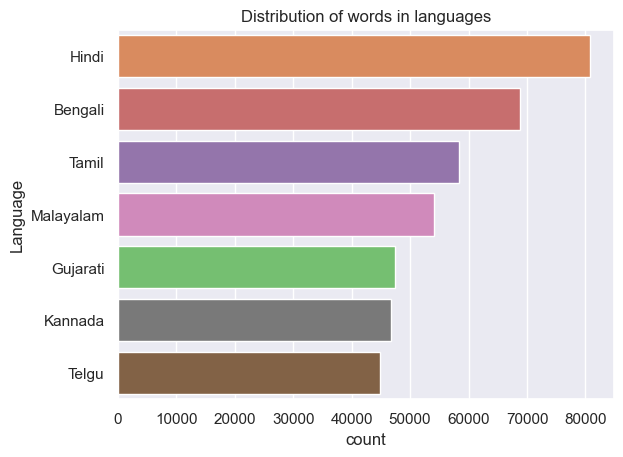

In [16]:
plot_data = lang_stats.describe().loc['count'].to_frame().reset_index(names=['Language'])
plot_data = plot_data[plot_data['Language'] != 'English']
sns.barplot(data = plot_data.sort_values(by='count', ascending=False), y='Language', x='count', palette=color_pallete)
plt.title('Distribution of words in languages')

plt.savefig('images/lang-distribution.pdf', bbox_inches="tight")
plt.savefig('images/lang-distribution.svg', bbox_inches="tight")

Plotting the distribution of the lengths of the sentences in each language. Here length refers to the number of words present in each language.

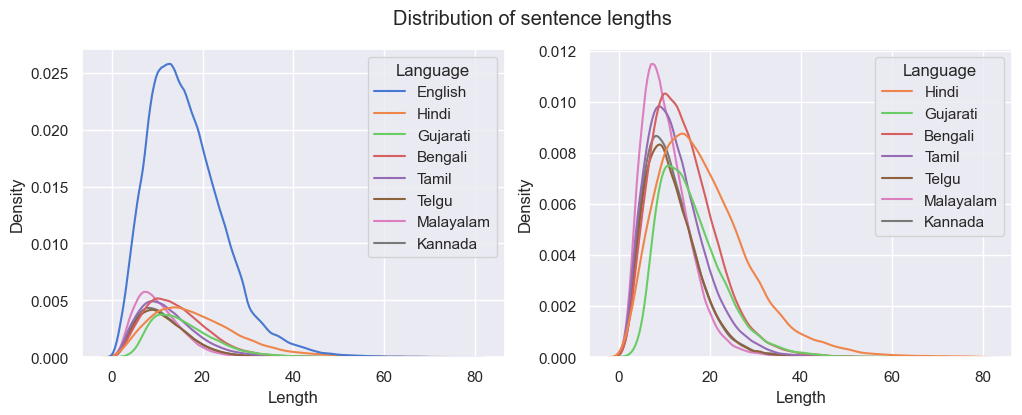

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_data = lang_stats[['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada']].melt().rename(columns={'variable': 'Language', 'value': 'Length'})
sns.kdeplot(plot_data[plot_data['Length'] < 80], x='Length', hue='Language', palette = color_pallete, ax = ax[0])

plot_data = lang_stats[['Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada']].melt().rename(columns={'variable': 'Language', 'value': 'Length'})
sns.kdeplot(plot_data[plot_data['Length'] < 80], x='Length', hue='Language', palette = color_pallete, ax = ax[1])


fig.suptitle('Distribution of sentence lengths')

plt.savefig('images/length-distribution.pdf', bbox_inches="tight")
plt.savefig('images/length-distribution.svg', bbox_inches="tight")

Plotting the Cumulative Distribution of the lengths of sequences in each language

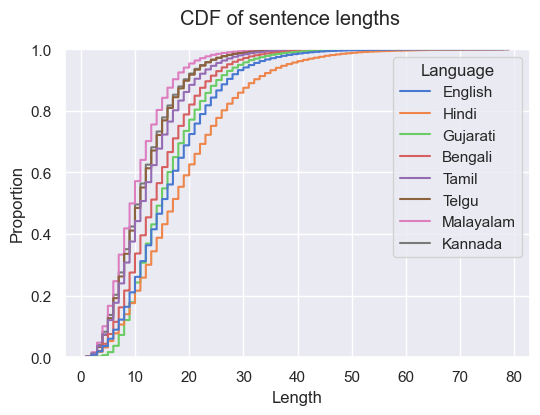

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_data = lang_stats[['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada']].melt().rename(columns={'variable': 'Language', 'value': 'Length'})
sns.ecdfplot(plot_data[plot_data['Length'] < 80], x='Length', hue='Language', palette = color_pallete)

fig.suptitle('CDF of sentence lengths')

plt.savefig('images/length-cdf.pdf', bbox_inches="tight")
plt.savefig('images/length-cdf.svg', bbox_inches="tight")

This shows that most of the sentences in the data are below 40 words. Thus we can see below that any sequence having more than 40 words is dropped in the training of the model

Plotting the distribution of unique words present in each language to understand vocabulary size

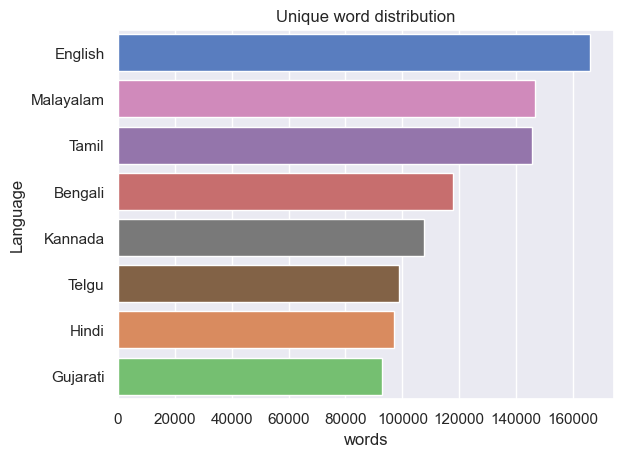

In [19]:
lang_sentences = pd.DataFrame(columns=['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada', 'id'])

lang_sentences['English'] = data['target'].apply(lambda x: x.split(' '))
lang_sentences['Hindi'] = data.loc[data['language'] == 'English-Hindi', 'source'].apply(lambda x: x.split(' '))
lang_sentences['Gujarati'] = data.loc[data['language'] == 'English-Gujarati', 'source'].apply(lambda x: x.split(' '))
lang_sentences['Bengali'] = data.loc[data['language'] == 'English-Bengali', 'source'].apply(lambda x: x.split(' '))
lang_sentences['Tamil'] = data.loc[data['language'] == 'English-Tamil', 'source'].apply(lambda x: x.split(' '))
lang_sentences['Telgu'] = data.loc[data['language'] == 'English-Telgu', 'source'].apply(lambda x: x.split(' '))
lang_sentences['Kannada'] = data.loc[data['language'] == 'English-Kannada', 'source'].apply(lambda x: x.split(' '))
lang_sentences['Malayalam'] = data.loc[data['language'] == 'English-Malayalam', 'source'].apply(lambda x: x.split(' '))
lang_sentences['id'] = data['id']

color_pallete = {}
pal = sns.color_palette('muted').as_hex()
for column, color in zip(['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada'], pal):
    color_pallete[column] = color

lang_sentences
# print(lang_stats.describe().astype(int).to_latex())
# lang_sentences.describe().astype(int)

def get_unique_words(lang):
    words = []
    for sentence in lang_sentences[lang].values:
        if type(sentence) is list:
            words.extend(list(sentence))
    return len(set(words))

lang_words = pd.DataFrame(index=['English', 'Hindi', 'Gujarati', 'Bengali', 'Tamil', 'Telgu', 'Malayalam', 'Kannada'], columns=['words'])
lang_words.loc['English', 'words'] = get_unique_words('English')
lang_words.loc['Hindi', 'words'] = get_unique_words('Hindi')
lang_words.loc['Gujarati', 'words'] = get_unique_words('Gujarati')
lang_words.loc['Bengali', 'words'] = get_unique_words('Bengali')
lang_words.loc['Tamil', 'words'] = get_unique_words('Tamil')
lang_words.loc['Telgu', 'words'] = get_unique_words('Telgu')
lang_words.loc['Malayalam', 'words'] = get_unique_words('Malayalam')
lang_words.loc['Kannada', 'words'] = get_unique_words('Kannada')

lang_words = lang_words.reset_index(names=['Language'])

sns.barplot(data = lang_words.sort_values(by='words', ascending=False), y='Language', x='words', palette=color_pallete)
plt.title('Unique word distribution')

plt.savefig('images/word-distribution.pdf', bbox_inches="tight")
plt.savefig('images/word-distribution.svg', bbox_inches="tight")


Plotting the length of source sequence vs the target sequence to get a rough estimate about the `max_len` while decoding

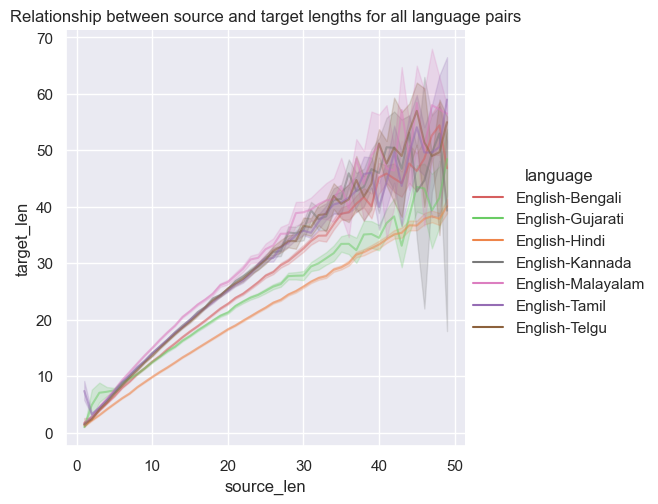

In [20]:
plot_data = data[['source_len', 'target_len', 'language']]

color_pallete = {}
pal = sns.color_palette('muted').as_hex()
for column, color in zip(['[]', 'English-Hindi', 'English-Gujarati', 'English-Bengali', 'English-Tamil', 'English-Telgu', 'English-Malayalam', 'English-Kannada'], pal):
    color_pallete[column] = color

sns.relplot(data=plot_data[plot_data['source_len'] < 50], x='source_len', y='target_len', hue='language', palette=color_pallete, kind='line', alpha=0.5)
plt.title('Relationship between source and target lengths for all language pairs')

plt.savefig('images/len-comparision.pdf', bbox_inches="tight")
plt.savefig('images/len-comparision.svg', bbox_inches="tight")


The data analysis results seem to be very consistent with the analysis results of Phase-1. So I will use only sentences below the length of 40 as they seem to capture about 90% of the data. I will keep the `max_len` of the target sentence to be equal to source sentence as that is the trend we can capture in the above graph, at least on word level and not on token/sub-token level.

## Data cleaning and pre-processing

Only using source and target pairs where the source length is less than 40

In [21]:
train_data = data.loc[data['source_len']<=40]

train_data

,id,source,target,language,source_len,target_len
0,0,তট্টেক্কাড়ুতে অনেক প্রজাতির পাখি ছাড়াও ২৮ প্...,The Bird Sanctuary of Tettekkad Idukki is worl...,English-Bengali,19,10
1,1,আমাদের দেশে প্রাচীনকালে বিদ্যা শেখানোর পরে বিদ...,The exam was taken of students after learning ...,English-Bengali,11,16
2,2,"১৩৩৬ খ্রিষ্টাব্দে কাজটি সম্পন্ন হলেও, পৃথ্বীরা...","While the work was completed in 1336 CE, the p...",English-Bengali,14,18
3,3,"ব্যবসায়ীরা সম্ভবত মঠগুলিতে দান করতেন, কারণ এই...",The merchants probably donated to the monaster...,English-Bengali,21,25
4,4,বাতই এক মাত্র স্টার্চ যেটা গ্যাস সৃষ্টি করে না ׀,Rice is the only starch which is not responsib...,English-Bengali,10,13
...,...,...,...,...,...,...
401238,1063020,జూన్ మూడో తేదీన ఏ ఆర్ రెహమాన్ కచేరి ఏ సమయంలో ప...,what time does the zach brown concert on june ...,English-Telgu,10,11
401239,1063021,మొక్క ప్రారంభం నుండి ఆరోగ్యంగా కనపడింది .,Plants were seen healthy since the beginning .,English-Telgu,6,8
401240,1063022,దీని ఉత్పత్తి కూడా సంవత్సరానికి సంబంధించి విత్...,Its yield is also annual which is grown again ...,English-Telgu,11,12
401241,1063023,ఖమ్మం నుండి నాసిక్ ముంబై వరకు ట్రైన్ సమయం,train time from brooklyn to queens,English-Telgu,7,6


### Preprocessing
1. Adding space before all punctuation marks in all languages to keep it persistent and help in assigning a single entry for punctuations in the vocab.
2. Adding space around commas to help in tokenization process
3. Adding space around brackets to aid in tokenization process
4. Adding space around any other special character to aid in tokenization
5. Stripping white-spaces from each sequence

In [22]:
import re
# from tqdm.notebook import tqdm_notebook
# tqdm_notebook().pandas()
tqdm.pandas(ncols=100)
def preprocess_1(sentence):
    
    # Full stops
    sentence = re.sub(r'(.)\ *\.', '\\1 .', sentence)
    sentence = re.sub(r'(.)\ *\|', '\\1 |', sentence)
    sentence = re.sub(r'(.)\ *\।', '\\1 |', sentence)
    
    # Commas
    sentence = re.sub(r'(.)\ *\,\ *(.)', '\\1 , \\2', sentence)
    
    # Brackets
    sentence = re.sub(r'\(\ *(.+)\ *\)', '( \\1 )', sentence)
    sentence = re.sub(r'\[\ *(.+)\ *\]', '( \\1 )', sentence)
    sentence = re.sub(r'\{\ *(.+)\ *\}', '( \\1 )', sentence)
    sentence = re.sub(r'\<\ *(.+)\ *\>', '( \\1 )', sentence)

    # Any special character
    sentence = re.sub(r'(.)\ *(\-)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\_)\ *(.)', '\\1 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\+)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\=)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\*)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\/)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\\)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\?)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\!)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\@)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\#)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\$)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\%)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\^)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\&)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\:)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\;)\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\')\ *(.)', '\\1 \\2 \\3', sentence)
    sentence = re.sub(r'(.)\ *(\")\ *(.)', '\\1 \\2 \\3', sentence)
    
    # repeated spaces
    sentence = re.sub(r'(.)\ +(.)', '\\1 \\2', sentence)
    sentence = sentence.strip()
    return sentence

def preprocess_row_1(row):
    if 'target' in row.keys():
        row['target'] = preprocess_1(row['target'])
    row['source'] = preprocess_1(row['source'])
    row['source_len'] = len(row['source'].split(' '))
    if 'target' in row.keys():
        row['target_len'] = len(row['target'].split(' '))
    return row

tqdm.pandas(desc='Preprocessing Train', ncols=100)
preprocessed_train = train_data.progress_apply(preprocess_row_1, axis=1)
tqdm.pandas(desc='Preprocessing Validation', ncols=100)
preprocessed_val = val_data.progress_apply(preprocess_row_1, axis=1)
tqdm.pandas(desc='Preprocessing Test', ncols=100)
preprocessed_test = test_data.progress_apply(preprocess_row_1, axis=1)
# preprocessed_train

Preprocessing Test: 100%|█████████████████████████████████| 114643/114643 [00:21<00:00, 5413.91it/s]


#### Preprocess 2
Changing all target sentences (in English) to lowercase. Used earlier but avoided later as the true sentences in English are not compared to lowercased sentences.

In [23]:
def preprocess_row_2(row):
    row['target'] = row['target'].lower()
    return row

# preprocessed_train = preprocessed_train.progress_apply(preprocess_row_2, axis=1)
# preprocessed_val = val_data.progress_apply(preprocess_row_2, axis=1)
# preprocessed_train

## Tokenization
Trying out all the tokenization strategies that I had tried during phase 1

- Word tokenization using `<whitespace>`
- spacy tokenization
- BPE
- Sentence-Piece (Best working model)

### Space Tokenizer

In [24]:
preprocessed_train['source_language'] = preprocessed_train['language'].apply(lambda x: x.split('-')[1])
preprocessed_train['target_language'] = preprocessed_train['language'].apply(lambda x: x.split('-')[0])

preprocessed_val['source_language'] = preprocessed_val['language'].apply(lambda x: x.split('-')[1])
preprocessed_val['target_language'] = preprocessed_val['language'].apply(lambda x: x.split('-')[0])

preprocessed_test['source_language'] = preprocessed_test['language'].apply(lambda x: x.split('-')[1])
preprocessed_test['target_language'] = preprocessed_test['language'].apply(lambda x: x.split('-')[0])

In [25]:
###############################################################################
# Word-level tokenization using <space>
###############################################################################

from collections import Counter
# from tqdm import tqdm
# Whitespace tokenization and vocab for English and all Indian languages together
class SpaceTokenizer:
    def __init__(self) -> None:
        self.tokenizer = {
            'English': Counter(),
            'Indian': Counter()
        }
    
    def make_vocab(self, source_max_vocab = 128_000, target_max_vocab = 32_000, specials = ['[PAD]', '[UNK]', '[SOS]', '[EOS]']):
        self.vocab_id2w = {
            'English': dict(enumerate(specials)),
            'Indian': dict(enumerate(specials))
        }
        self.vocab_w2id = {
            'English': dict(),
            'Indian': dict()
        }
        
        id = len(specials)
        for w, _ in self.tokenizer['English'].most_common(target_max_vocab - len(specials)):
            self.vocab_id2w['English'][id] = w
            id+=1
        self.vocab_w2id['English'] = {v:k for k, v in self.vocab_id2w['English'].items()}
        
        id = len(specials)
        for w, _ in self.tokenizer['Indian'].most_common(source_max_vocab - len(specials)):
            self.vocab_id2w['Indian'][id] = w
            id+=1
        self.vocab_w2id['Indian'] = {v:k for k, v in self.vocab_id2w['Indian'].items()}
    
    def encode(self, sentence, language):
        tokens = self.get_tokens(sentence)
        return [self.vocab_w2id[language][word] if word in self.vocab_w2id[language] else 1 for word in tokens]
    
    def decode(self, tokens, language):
        return self.join_tokens([self.vocab_id2w[language][word] for word in tokens])
    
    def get_tokens(self, sentence):
        return sentence.split(' ')
    
    def join_tokens(self, tokens):
        return ' '.join(tokens)
    

def train_tokenizer(row, tokenizer):
    source_tokens = tokenizer.get_tokens(row['source'])
    target_tokens = tokenizer.get_tokens(row['target'])
    for token in source_tokens:
        tokenizer.tokenizer['Indian'][token] += 1
    for token in target_tokens:
        tokenizer.tokenizer['English'][token] += 1


        
space_tokenizer = SpaceTokenizer()
preprocessed_train.apply(lambda x: train_tokenizer(x, space_tokenizer), axis=1)
space_tokenizer.make_vocab(source_max_vocab=7*64_000, target_max_vocab=80_000)

tqdm.pandas(desc='Tokenizing Train targets', ncols=100)
preprocessed_train['target_tokens'] = preprocessed_train.progress_apply(lambda x: space_tokenizer.encode(x['target'], 'English'), axis=1)
tqdm.pandas(desc='Tokenizing Train sources', ncols=100)
preprocessed_train['source_tokens'] = preprocessed_train.progress_apply(lambda x: space_tokenizer.encode(x['source'], 'Indian'), axis=1)
tqdm.pandas(desc='Tokenizing Validation sources', ncols=100)
preprocessed_val['source_tokens'] = preprocessed_val.progress_apply(lambda x: space_tokenizer.encode(x['source'], 'Indian'), axis=1)
tqdm.pandas(desc='Tokenizing Test sources', ncols=100)
preprocessed_test['source_tokens'] = preprocessed_test.progress_apply(lambda x: space_tokenizer.encode(x['source'], 'Indian'), axis=1)

SOURCE_VOCAB = len(space_tokenizer.vocab_w2id['Indian'])
TARGET_VOCAB = len(space_tokenizer.vocab_w2id['English'])

print(f'SOURCE_VOCAB: {SOURCE_VOCAB}, TARGET_VOCAB: {TARGET_VOCAB}')

ids = space_tokenizer.encode('today is a divyaksh shukla', 'English')
display(ids)
display(space_tokenizer.decode(ids, 'English'))

Tokenizing Test sources: 100%|██████████████████████████| 114643/114643 [00:01<00:00, 108752.26it/s]

SOURCE_VOCAB: 448000, TARGET_VOCAB: 80000


[154, 10, 12, 1, 1]

'today is a [UNK] [UNK]'

In [26]:
# Saving data
preprocessed_train_filepath = os.path.join('answers',experiment_id, 'preprocessed_space_train.pkl')
preprocessed_train.to_pickle(preprocessed_train_filepath)

# Saving tokenizer
space_tokenizer_filepath = os.path.join('answers',experiment_id, 'space_tokenizer.pkl')

# Saving validation data
preprocessed_val_filepath = os.path.join('answers',experiment_id, 'preprocessed_space_val.pkl')
preprocessed_val.to_pickle(preprocessed_val_filepath)

# Saving test data
preprocessed_test_filepath = os.path.join('answers',experiment_id, 'preprocessed_space_test.pkl')
preprocessed_test.to_pickle(preprocessed_test_filepath)

### Byte-Pair Encoding

In [27]:
preprocessed_train['source_language'] = preprocessed_train['language'].apply(lambda x: x.split('-')[1])
preprocessed_train['target_language'] = preprocessed_train['language'].apply(lambda x: x.split('-')[0])

preprocessed_val['source_language'] = preprocessed_val['language'].apply(lambda x: x.split('-')[1])
preprocessed_val['target_language'] = preprocessed_val['language'].apply(lambda x: x.split('-')[0])

preprocessed_test['source_language'] = preprocessed_test['language'].apply(lambda x: x.split('-')[1])
preprocessed_test['target_language'] = preprocessed_test['language'].apply(lambda x: x.split('-')[0])

#### BPE separately for each language

In [36]:
###############################################################################
# BPE Tokenization using huggingface tokenizer and training from 
# scratch
###############################################################################

class MTBPETokenizer:
    def __init__(self) -> None:
        Tokenizer(BPE(unk_token = "[UNK]"))
        self.tokenizer = {
            'English': Tokenizer(BPE(unk_token = "[UNK]")),
            'Hindi': Tokenizer(BPE(unk_token = "[UNK]")),
            'Gujarati': Tokenizer(BPE(unk_token = "[UNK]")),
            'Bengali': Tokenizer(BPE(unk_token = "[UNK]")),
            'Tamil': Tokenizer(BPE(unk_token = "[UNK]")),
            'Telgu': Tokenizer(BPE(unk_token = "[UNK]")),
            'Malayalam': Tokenizer(BPE(unk_token = "[UNK]")),
            'Kannada': Tokenizer(BPE(unk_token = "[UNK]"))
        }
        for k in self.tokenizer.keys():
            self.tokenizer[k].pre_tokenizer = Whitespace()
        

    def train_tokenizer(self, data, 
                        source_max_vocab = 32_000, 
                        target_max_vocab = 32_000, 
                        specials = ['[PAD]', '[UNK]', '[SOS]', '[EOS]']):
        
        self.trainer = BpeTrainer(special_tokens=specials, 
                                  vocab_size=source_max_vocab, 
                                  show_progress=True, 
                                  limit_alphabet=500, 
                                  min_frequency=5)
        
        for lang in self.tokenizer.keys():
            lang_data = data[data['source_language'] == lang]
            lang_text = lang_data.loc[:, 'source'].values
            self.tokenizer[lang].train_from_iterator(lang_text,
                                                     self.trainer)
        
        english_text = data.loc[:, 'target'].values
        self.tokenizer['English'].train_from_iterator(english_text, 
                                                      self.trainer)
            
    def encode(self, sentence, language):
        tokens = self.tokenizer[language].encode(sentence).ids
        return tokens

    def decode(self, tokens, language):
        return self.tokenizer[language].decode(tokens)

    def get_tokens(self, sentence, language):
        return self.tokenizer[language].encode(sentence).tokens

    def join_tokens(self, tokens):
        pass

    
        
bpe_tokenizer = MTBPETokenizer()
bpe_tokenizer.train_tokenizer(preprocessed_train, source_max_vocab=32_000, target_max_vocab=32_000)

tqdm.pandas(desc='Tokenizing Train targets', ncols=100)
preprocessed_train['target_tokens'] = preprocessed_train.progress_apply(lambda x: bpe_tokenizer.encode(x['target'], 'English'), axis=1)
tqdm.pandas(desc='Tokenizing Train sources', ncols=100)
preprocessed_train['source_tokens'] = preprocessed_train.progress_apply(lambda x: bpe_tokenizer.encode(x['source'], x['source_language']), axis=1)

tqdm.pandas(desc='Tokenizing Validation sources', ncols=100)
preprocessed_val['source_tokens'] = preprocessed_val.progress_apply(lambda x: bpe_tokenizer.encode(x['source'], x['source_language']), axis=1)
tqdm.pandas(desc='Tokenizing Test sources', ncols=100)
preprocessed_test['source_tokens'] = preprocessed_test.progress_apply(lambda x: bpe_tokenizer.encode(x['source'], x['source_language']), axis=1)

ids = space_tokenizer.encode('today is a divyaksh shukla', 'English')
display(ids)
display(space_tokenizer.decode(ids, 'English'))


Tokenizing Test sources: 100%|███████████████████████████| 114643/114643 [00:04<00:00, 25546.08it/s]


[154, 10, 12, 1, 1]

'today is a [UNK] [UNK]'

In [37]:
# Saving data
preprocessed_train_filepath = os.path.join('answers',experiment_id, 'preprocessed_separate_bpe_train.pkl')
preprocessed_train.to_pickle(preprocessed_train_filepath)

# Saving tokenizer
bpe_tokenizer_filepath = os.path.join('answers',experiment_id, 'separate_bpe_tokenizer.pkl')

# Saving validation data
preprocessed_val_filepath = os.path.join('answers',experiment_id, 'preprocessed_separate_bpe_val.pkl')
preprocessed_val.to_pickle(preprocessed_val_filepath)

# Saving test data
preprocessed_test_filepath = os.path.join('answers',experiment_id, 'preprocessed_separate_bpe_test.pkl')
preprocessed_test.to_pickle(preprocessed_test_filepath)

#### Common BPE for all Indian Languages

In [38]:
###############################################################################
# BPE Tokenization using huggingface tokenizer and training from 
# scratch
###############################################################################

class MTBPETokenizer:
    def __init__(self) -> None:
        Tokenizer(BPE(unk_token = "[UNK]"))
        self.tokenizer = {
            'English': Tokenizer(BPE(unk_token = "[UNK]")),
            'Indian': Tokenizer(BPE(unk_token = "[UNK]"))
        }
        for k in self.tokenizer.keys():
            self.tokenizer[k].pre_tokenizer = Whitespace()
        

    def train_tokenizer(self, data, 
                        source_max_vocab = 7*32_000, 
                        target_max_vocab = 32_000, 
                        specials = ['[PAD]', '[UNK]', '[SOS]', '[EOS]']):
        
        indian_trainer = BpeTrainer(special_tokens=specials, 
                                  vocab_size=source_max_vocab, 
                                  show_progress=True, 
                                  limit_alphabet=500, 
                                  min_frequency=5)
        
        # for lang in self.tokenizer.keys():
        # lang_data = data[data['source_language'] == lang]
        lang_text = data.loc[:, 'source'].values
        self.tokenizer["Indian"].train_from_iterator(lang_text,
                                                    indian_trainer)
        
        en_trainer = BpeTrainer(special_tokens=specials, 
                                  vocab_size=target_max_vocab, 
                                  show_progress=True, 
                                  limit_alphabet=500, 
                                  min_frequency=5)
        
        english_text = data.loc[:, 'target'].values
        self.tokenizer['English'].train_from_iterator(english_text, 
                                                      en_trainer)
            
    def encode(self, sentence, language):
        tokens = self.tokenizer[language].encode(sentence).ids
        return tokens

    def decode(self, tokens, language):
        return self.tokenizer[language].decode(tokens)

    def get_tokens(self, sentence, language):
        return self.tokenizer[language].encode(sentence).tokens

    def join_tokens(self, tokens):
        pass

    
        
bpe_tokenizer = MTBPETokenizer()
bpe_tokenizer.train_tokenizer(preprocessed_train, source_max_vocab=7*32_000, target_max_vocab=32_000)

tqdm.pandas(desc='Tokenizing Train targets', ncols=100)
preprocessed_train['target_tokens'] = preprocessed_train.progress_apply(lambda x: bpe_tokenizer.encode(x['target'], 'English'), axis=1)
tqdm.pandas(desc='Tokenizing Train sources', ncols=100)
preprocessed_train['source_tokens'] = preprocessed_train.progress_apply(lambda x: bpe_tokenizer.encode(x['source'], 'Indian'), axis=1)

tqdm.pandas(desc='Tokenizing Validation sources', ncols=100)
preprocessed_val['source_tokens'] = preprocessed_val.progress_apply(lambda x: bpe_tokenizer.encode(x['source'], 'Indian'), axis=1)
tqdm.pandas(desc='Tokenizing Test sources', ncols=100)
preprocessed_test['source_tokens'] = preprocessed_test.progress_apply(lambda x: bpe_tokenizer.encode(x['source'], 'Indian'), axis=1)
# preprocessed_train

Tokenizing Test sources: 100%|███████████████████████████| 114643/114643 [00:05<00:00, 21744.70it/s]


In [39]:
# Saving data
preprocessed_train_filepath = os.path.join('answers',experiment_id, 'preprocessed_bpe_train.pkl')
preprocessed_train.to_pickle(preprocessed_train_filepath)

# Saving tokenizer
bpe_tokenizer_filepath = os.path.join('answers',experiment_id, 'bpe_tokenizer.pkl')

# Saving validation data
preprocessed_val_filepath = os.path.join('answers',experiment_id, 'preprocessed_bpe_val.pkl')
preprocessed_val.to_pickle(preprocessed_val_filepath)

# Saving test data
preprocessed_test_filepath = os.path.join('answers',experiment_id, 'preprocessed_bpe_test.pkl')
preprocessed_test.to_pickle(preprocessed_test_filepath)

### SentencePiece Tokenizer

In [40]:
preprocessed_train['source_language'] = preprocessed_train['language'].apply(lambda x: x.split('-')[1])
preprocessed_train['target_language'] = preprocessed_train['language'].apply(lambda x: x.split('-')[0])

preprocessed_val['source_language'] = preprocessed_val['language'].apply(lambda x: x.split('-')[1])
preprocessed_val['target_language'] = preprocessed_val['language'].apply(lambda x: x.split('-')[0])

preprocessed_test['source_language'] = preprocessed_test['language'].apply(lambda x: x.split('-')[1])
preprocessed_test['target_language'] = preprocessed_test['language'].apply(lambda x: x.split('-')[0])
# preprocessed_train

##### Sentence Piece for each source language

In [41]:
###############################################################################
# SentencePiece Tokenization using huggingface tokenizer and training from 
# scratch
###############################################################################

class MTSentencePieceTokenizer:
    def __init__(self) -> None:
        self.tokenizer = {
            'English': SentencePieceBPETokenizer(),
            'Hindi': SentencePieceBPETokenizer(),
            'Gujarati': SentencePieceBPETokenizer(),
            'Bengali': SentencePieceBPETokenizer(),
            'Tamil': SentencePieceBPETokenizer(),
            'Telgu': SentencePieceBPETokenizer(),
            'Malayalam': SentencePieceBPETokenizer(),
            'Kannada': SentencePieceBPETokenizer()
        }

    def train_tokenizer(self, data, source_max_vocab = 32_000, target_max_vocab = 32_000, specials = ['[PAD]', '[UNK]', '[SOS]', '[EOS]']):
        for lang in self.tokenizer.keys():
            lang_data = data[data['source_language'] == lang]
            lang_text = lang_data.loc[:, 'source'].values
            self.tokenizer[lang].train_from_iterator(lang_text, 
                                                     vocab_size=source_max_vocab,
                                                     min_frequency=5,
                                                     show_progress=True,
                                                     limit_alphabet=500)
        english_text = data.loc[:, 'target'].values
        self.tokenizer['English'].train_from_iterator(english_text,
                                                      vocab_size=target_max_vocab,
                                                      min_frequency=5,
                                                      show_progress=True,
                                                      limit_alphabet=500)
            
    def encode(self, sentence, language):
        tokens = self.tokenizer[language].encode(sentence).ids
        return tokens

    def decode(self, tokens, language):
        return self.tokenizer[language].decode(tokens)

    def get_tokens(self, sentence, language):
        return self.tokenizer[language].encode(sentence).tokens

    def join_tokens(self, tokens):
        pass

    
        
sp_tokenizer = MTSentencePieceTokenizer()
sp_tokenizer.train_tokenizer(preprocessed_train, source_max_vocab=32_000, target_max_vocab=32_000)

tqdm.pandas(desc='Tokenizing Train targets', ncols=100)
preprocessed_train['target_tokens'] = preprocessed_train.progress_apply(lambda x: sp_tokenizer.encode(x['target'], 'English'), axis=1)
tqdm.pandas(desc='Tokenizing Train sources', ncols=100)
preprocessed_train['source_tokens'] = preprocessed_train.progress_apply(lambda x: sp_tokenizer.encode(x['source'], x['source_language']), axis=1)

tqdm.pandas(desc='Tokenizing Validation sources', ncols=100)
preprocessed_val['source_tokens'] = preprocessed_val.progress_apply(lambda x: sp_tokenizer.encode(x['source'], x['source_language']), axis=1)
tqdm.pandas(desc='Tokenizing Test sources', ncols=100)
preprocessed_test['source_tokens'] = preprocessed_test.progress_apply(lambda x: sp_tokenizer.encode(x['source'], x['source_language']), axis=1)

Tokenizing Test sources: 100%|███████████████████████████| 114643/114643 [00:05<00:00, 19508.17it/s]


##### Sentence Piece for all indian languages together

In [42]:
###############################################################################
# SentencePiece Tokenization using huggingface tokenizer and training from 
# scratch
###############################################################################

class MTSentencePieceTokenizer:
    def __init__(self) -> None:
        self.tokenizer = {
            'English': SentencePieceBPETokenizer(),
            'Indian':  SentencePieceBPETokenizer()
        }

    def train_tokenizer(self, data, source_max_vocab = 32_000, target_max_vocab = 32_000, specials = ['[PAD]', '[UNK]', '[SOS]', '[EOS]']):
        lang_text = data.loc[:, 'source'].values
        self.tokenizer['Indian'].train_from_iterator(lang_text, 
                                                    vocab_size=source_max_vocab,
                                                    min_frequency=5,
                                                    show_progress=True,
                                                    limit_alphabet=500)
        english_text = data.loc[:, 'target'].values
        self.tokenizer['English'].train_from_iterator(english_text,
                                                      vocab_size=target_max_vocab,
                                                      min_frequency=5,
                                                      show_progress=True,
                                                      limit_alphabet=500)
            
    def encode(self, sentence, language):
        tokens = self.tokenizer[language].encode(sentence).ids
        return tokens

    def decode(self, tokens, language):
        return self.tokenizer[language].decode(tokens)

    def get_tokens(self, sentence, language):
        return self.tokenizer[language].encode(sentence).tokens

    def join_tokens(self, tokens):
        pass

    
        
sp_tokenizer = MTSentencePieceTokenizer()
sp_tokenizer.train_tokenizer(preprocessed_train, source_max_vocab=60_000, target_max_vocab=10_000)

tqdm.pandas(desc='Encoding Train target', ncols=100)
preprocessed_train['target_tokens'] = preprocessed_train.progress_apply(lambda x: sp_tokenizer.encode(x['target'], 'English'), axis=1)
tqdm.pandas(desc='Encoding Train source', ncols=100)
preprocessed_train['source_tokens'] = preprocessed_train.progress_apply(lambda x: sp_tokenizer.encode(x['source'], 'Indian'), axis=1)

tqdm.pandas(desc='Encoding Validation source', ncols=100)
preprocessed_val['source_tokens'] = preprocessed_val.progress_apply(lambda x: sp_tokenizer.encode(x['source'], 'Indian'), axis=1)

tqdm.pandas(desc='Encoding Test source', ncols=100)
preprocessed_test['source_tokens'] = preprocessed_test.progress_apply(lambda x: sp_tokenizer.encode(x['source'], 'Indian'), axis=1)
# preprocessed_train

Encoding Test source: 100%|██████████████████████████████| 114643/114643 [00:07<00:00, 15502.02it/s]


#### Saving Preprocessed data and tokenizer

In [43]:
# Saving data
preprocessed_train_filepath = os.path.join('answers', experiment_id, 'preprocessed_sp_train.pkl')
preprocessed_train.to_pickle(preprocessed_train_filepath)

# Saving tokenizer
sp_tokenizer_filepath = os.path.join('answers', experiment_id, 'sp_tokenizer.pkl')
import pickle
with open(sp_tokenizer_filepath, 'wb') as f:
    pickle.dump(sp_tokenizer, f)

# Saving val data
preprocessed_val_filepath = os.path.join('answers', experiment_id, 'preprocessed_sp_val.pkl')
preprocessed_val.to_pickle(preprocessed_val_filepath)

# Saving test data
preprocessed_test_filepath = os.path.join('answers', experiment_id, 'preprocessed_sp_test.pkl')
preprocessed_test.to_pickle(preprocessed_test_filepath)

In [44]:
SOURCE_VOCAB = len(sp_tokenizer.tokenizer['Indian'].get_vocab())
TARGET_VOCAB = len(sp_tokenizer.tokenizer['English'].get_vocab())

f'SOURCE VOCAB: {SOURCE_VOCAB} | TARGET VOCAB: {TARGET_VOCAB}'

'SOURCE VOCAB: 60000 | TARGET VOCAB: 10000'

In [45]:
# Loading tokenizer
sp_tokenizer_filepath = os.path.join(project_dir, experiment_id, 'sp_tokenizer.pkl')
import pickle
with open(sp_tokenizer_filepath, 'rb') as f:
    sp_tokenizer = pickle.load(f)

In [46]:
SOURCE_VOCAB = len(sp_tokenizer.tokenizer['Indian'].get_vocab())
TARGET_VOCAB = len(sp_tokenizer.tokenizer['English'].get_vocab())

f'SOURCE VOCAB: {SOURCE_VOCAB} | TARGET VOCAB: {TARGET_VOCAB}'

'SOURCE VOCAB: 60000 | TARGET VOCAB: 10000'

## Loading pre-processed data and tokenizer

In [47]:
# Loading data
preprocessed_train_filepath = os.path.join(project_dir, experiment_id, 'preprocessed_sp_train.pkl')
preprocessed_train = pd.read_pickle(preprocessed_train_filepath)

# Loading validation data
preprocessed_val_filepath = os.path.join(project_dir,experiment_id, 'preprocessed_sp_val.pkl')
preprocessed_val = pd.read_pickle(preprocessed_val_filepath)

# Loading testing data
preprocessed_test_filepath = os.path.join(project_dir,experiment_id, 'preprocessed_sp_test.pkl')
preprocessed_test = pd.read_pickle(preprocessed_test_filepath)

# preprocessed_train = preprocessed_train[preprocessed_train['source_language'] == 'Hindi']
display(preprocessed_train.shape)
display(preprocessed_train.head())
display(preprocessed_val.head())

(396865, 10)

,id,source,target,language,source_len,target_len,source_language,target_language,target_tokens,source_tokens
0,0,তট্টেক্কাড়ুতে অনেক প্রজাতির পাখি ছাড়াও ২৮ প্...,The Bird Sanctuary of Tettekkad Idukki is worl...,English-Bengali,19,10,Bengali,English,"[462, 5034, 69, 4402, 412, 442, 458, 662, 76, ...","[640, 10663, 1425, 1668, 1506, 14299, 2189, 11..."
1,1,আমাদের দেশে প্রাচীনকালে বিদ্যা শেখানোর পরে বিদ...,The exam was taken of students after learning ...,English-Bengali,11,16,Bengali,English,"[462, 1586, 540, 1612, 412, 4330, 754, 5753, 2...","[5192, 9881, 5465, 6454, 56658, 18417, 4020, 3..."
2,2,"১৩৩৬ খ্রিষ্টাব্দে কাজটি সম্পন্ন হলেও , পৃথ্বীর...","While the work was completed in 1336 CE , the ...",English-Bengali,16,20,Bengali,English,"[2077, 403, 944, 540, 4424, 425, 2191, 5576, 4...","[12009, 184, 187, 18192, 2751, 664, 23739, 210..."
3,3,"ব্যবসায়ীরা সম্ভবত মঠগুলিতে দান করতেন , কারণ এ...",The merchants probably donated to the monaster...,English-Bengali,23,27,Bengali,English,"[462, 7859, 1001, 4272, 1850, 582, 434, 403, 8...","[16657, 6261, 14789, 37661, 6027, 16605, 14272..."
4,4,বাতই এক মাত্র স্টার্চ যেটা গ্যাস সৃষ্টি করে না ׀,Rice is the only starch which is not responsib...,English-Bengali,10,13,Bengali,English,"[9335, 437, 403, 790, 471, 1233, 587, 437, 576...","[9320, 131, 831, 4756, 24690, 1096, 6309, 2283..."


,id,source,language,source_len,source_language,target_language,source_tokens
0,68848,শাসক স্যার তাঘতসিনজি গোহিলের অতীতের দর্শন বর্ত...,English-Bengali,11,Bengali,English,"[20927, 50022, 3069, 139, 151, 27697, 5057, 74..."
1,68849,আপনার ই পি এফ ও - তে নিবন্ধিত মোবাইল নম্বরের ল...,English-Bengali,16,Bengali,English,"[2304, 1121, 4265, 13401, 894, 568, 5037, 4527..."
2,68850,"৩৫০ বর্গফুট আয়তনের এই কক্ষে একটি টেলিফোন , এক...",English-Bengali,15,Bengali,English,"[55419, 9209, 157, 8340, 45821, 1376, 963, 517..."
3,68851,"দীর্ঘমেয়াদী চিকিত্সা পরিকল্পনা , চিকিত্সার ফল...",English-Bengali,22,Bengali,English,"[8720, 58519, 12350, 10471, 503, 18902, 27514,..."
4,68852,"প্রসার শিক্ষা নির্দেশক , ডা . ডওয়াস বলেছেন যে ...",English-Bengali,36,Bengali,English,"[20245, 14192, 51681, 503, 21728, 501, 1436, 9..."


## Loading vectors of tokens

Using fastText API along with IndicNLP (pre-trained) fastText model to assign vector representations to each token. FastText works on sub-token level so I have changed the tokenizer to SentencePiece as that is what is used by FastText.

## Data loader, sorting and padding

In [ ]:
from random import choice
class MTDataset(Dataset):
    def __init__(self, sources, targets, ids):
        super().__init__()
        self.sources = sources
        self.targets = targets
        self.ids = ids
    def __getitem__(self, index):
        if len(self.targets) > 0:
            # index = choice([0,10000])
            return (
                # self.sources[index], # source
                np.concatenate((np.array([2]), self.sources[index], np.array([3])), axis=0), # source
                np.concatenate((self.targets[index], np.array([3])), axis=0), # target-output
                np.concatenate((np.array([2]), self.targets[index]), axis=0), # target-input
                self.ids[index])
        return (np.concatenate((np.array([2]), self.sources[index], np.array([3])), axis=0), [], [], self.ids[index]) # source

    def __len__(self):
        return len(self.sources)

def pad_source_targets(batch, max_len = 120):
    sources = pad_sequence([torch.tensor(s) for s, _, _, _ in batch], batch_first=False)
    target_output = pad_sequence([torch.tensor(t) for _, t, _, _ in batch], batch_first=False)
    target_input = pad_sequence([torch.tensor(t) for _, _, t, _ in batch], batch_first=False)
    ids = torch.tensor([torch.tensor(idx) for _, _, _, idx in batch])
    return sources, target_output, target_input, ids

train_data = preprocessed_train.copy()

dataset = MTDataset(train_data['source_tokens'].values, train_data['target_tokens'].values, train_data['id'].astype('int').values)

random_sampler = RandomSampler(data_source=dataset, num_samples=7*6000)

SOURCE_EMBEDDING_VOCAB = SOURCE_VOCAB
dataloader = DataLoader(dataset, sampler = random_sampler, batch_size = TRAIN_BATCH_SIZE, collate_fn=pad_source_targets)

dataloader

## Model

Using a transformer model from pytorch tutorial 

In [ ]:
###############################################################################
# Transformer Model
###############################################################################

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

    
class TokenEmbedding(nn.Module):
    '''
    Convert token values to embedding values, also apply
    scaling with respect to dimensions of the embedding
    '''
    def __init__(self, vocab_size: int, emb_size: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=0, device=device)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)
    

class Seq2SeqTransformer(nn.Module):
    '''
    Seq2Seq network based on 'Attention is all you need'
    '''
    def __init__(self,
                 num_encoder_layers: int = 3, num_decoder_layers: int = 3,
                 emb_size: int = 512, n_heads: int = 8, 
                 src_vocab_size = 7*32_000, tgt_vocab_size = 32_000,
                 dim_feedforward = 512,
                 dropout = 0.1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.transformer = nn.Transformer(d_model = emb_size,
                                          nhead=n_heads,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout, batch_first=False)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout = dropout)
    
    def forward(self, src: Tensor, target: Tensor,
                src_mask: Tensor, target_mask: Tensor,
                source_padding_mask: Tensor, target_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src.to(device)))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(target.to(device)))
        outs = self.transformer(src_emb, tgt_emb, src_mask, target_mask, None, 
                                source_padding_mask, target_padding_mask, memory_key_padding_mask)
        return self.generator(outs)
    
    def encode(self, src: Tensor, src_mask: Tensor, src_key_padding_mask=None):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask, src_key_padding_mask)
    
    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)
    
    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)


In [ ]:
# utility methods for train loop
def showLossPlot(losses: list):
    plt.plot(losses)
    plt.title('Loss Curve')
    
def generate_square_subsequent_mask(size):
    mask = torch.triu(torch.ones((size, size)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask==1, float(0.0))
    return mask
    
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len).to(device)
    src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool).to(device)

    src_padding_mask = (src == 0).transpose(0, 1).to(device)
    tgt_padding_mask = (tgt == 0).transpose(0, 1).to(device)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
def save_model(model, optimizer, loss_fn, epochs, this_epochs, model_filepath, plot_losses = None):
    """Save the model and hyperparameters to `model_filepath`

    Args:
        model (nn.Module): Object of the model to be saved.
        optimizer (torch.optim): Optimizer object.
        loss_fn (nn.*): Loss function object.
        epochs (int): Previous epochs, if model was trained. Give 0 if default.
        this_epochs (int): Number of epochs trained in the current execution.
        model_filepath (str): PATH of the model.
    """
    torch.save({
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer': optimizer,
            'optim_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            'loss_state_dict': loss_fn.state_dict(),
            'epochs': epochs + this_epochs,
            'plot_losses': plot_losses
        }, model_filepath)

In [ ]:
def train_epoch_trf(dataloader, model, optimizer, loss_fn, epochs, epoch, encoder_eval = False):
    total_loss = 0
    batch_losses = []

    model.train()
    optimizer.zero_grad()
    
    effective_batch_size = 13
    n_batches = int(len(dataloader)/(effective_batch_size)) + 1
    batch_counter = 0
    show_after = 350
    
    loss = 0
    
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader), ncols=100, desc=f"Training epoch {epochs + epoch + 1}"):
        
        source = batch[0].to(device)
        batch_size = source.size(1)

        target_output = batch[1].to(device)

        target_input = batch[2].to(device)

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(source, target_input)

        logits = model(source, target_input, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)

        loss = loss_fn(
            logits.view(-1, logits.size(-1)),
            target_output.type(torch.long).reshape(-1))

        loss = loss / effective_batch_size

        loss.backward()

        total_loss += loss.item()*effective_batch_size
        batch_losses.append(loss.item())
        if ((batch_idx+1) % effective_batch_size == 0) or (batch_idx + 1 == len(dataloader)):
            writer.add_scalar('Batch Loss', loss, (epochs + epoch) * n_batches + batch_counter)
            batch_counter += 1
            optimizer.step()
            optimizer.zero_grad()

    gc.collect()
    return total_loss/len(dataloader), batch_losses

def train_and_save(data, tokenizer, model, optimizer, loss_fn, batch_size, epochs, this_epochs, model_filepath, encoder_eval = False):
    try:
        plot_losses = []
        plot_batch_losses = []
        

        for epoch in range(0, this_epochs):
            loss, batch_loss = train_epoch_trf(dataloader, model, optimizer, loss_fn, epochs = epochs, epoch=epoch, encoder_eval=encoder_eval)
            print(f'Train Loss: {loss}')
            writer.add_scalar('Train Loss', loss, epochs + epoch)
            print(f'Batch Loss: {batch_loss}')
            # writer.add_scalars('Batch Loss', batch_loss, epoch)
            plot_losses.append(loss)
            plot_batch_losses.extend(batch_loss)
            save_model(model, optimizer, loss_fn, epochs, epoch, model_filepath, plot_losses=plot_losses)
        # print(f'Complete train loss: {plot_batch_losses}')
        showLossPlot(plot_batch_losses)
        # print(plot_batch_losses)
        return plot_losses, plot_batch_losses
    except Exception as e:
        raise e
    finally:
        save_model(model, optimizer, loss_fn, epochs, epoch, model_filepath, plot_losses=plot_losses)

In [ ]:
plot_losses = []

In [ ]:
def load_weights_if_exists(model, optimizer, loss_fn, plot_losses, epochs, model_filepath):
    """Loads the existing model from `model_filepath`

    Args:
        model (nn.Module): The model who's weights are loaded
        optimizer : Model optimizer
        loss_fn : Model Loss function
        plot_losses : An array to capture batch losses
        epochs : No. of epochs done by the model
        model_filepath (str): Filepath of the model

    Returns:
        model (nn.Module): The model who's weights are loaded
        optimizer : Model optimizer
        loss_fn : Model Loss function
        plot_losses : An array to capture batch losses
        epochs : No. of epochs done by the model
    """
    if os.path.exists(model_filepath):
        print('Loading stored weights')
        states = torch.load(model_filepath, map_location=device)
        if 'model' in states:
            model = states['model']
        if 'model_state_dict' in states:
            model.load_state_dict(states['model_state_dict'])
        if 'optimizer' in states:
            optimizer = states['optimizer']
        if 'optim_state_dict' in states:
            optimizer.load_state_dict(states['optim_state_dict'])
        if 'loss_fn' in states:
            loss_fn = states['loss_fn']
        if 'loss_state_dict' in states:
            loss_fn.load_state_dict(states['loss_state_dict'])
        if 'plot_losses' in states:
            plot_losses = states['plot_losses']
        if 'epochs' in states:
            epochs = states['epochs']
        model = model.to(device)
    return model, optimizer, loss_fn, plot_losses, epochs

In [ ]:
###############################################################################
# Defining the model
###############################################################################
model = Seq2SeqTransformer(
     num_encoder_layers=ENCODER_NUM_LAYERS,
     num_decoder_layers=DECODER_NUM_LAYERS,
     n_heads=N_ATTENTION_HEADS,
     src_vocab_size=SOURCE_VOCAB,
     tgt_vocab_size=TARGET_VOCAB).to(device)

# Model weight initialization
for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

###############################################################################
# Initializing optimizer and loss function
###############################################################################
optimizer = optim.Adam(model.parameters(), lr = 1e-3, betas=(0.9, 0.98), eps=1e-9)
# optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-6)
# optimizer = optim.SGD(model.parameters(), lr = 1e-10)
# loss_fn = nn.NLLLoss()
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

###############################################################################
# Epochs
###############################################################################
this_epochs = 40
epochs = 0

###############################################################################
# Loading model and trainer if exists
###############################################################################
model, optimizer, loss_fn, plot_losses, epochs = load_weights_if_exists(
     model, optimizer, loss_fn, plot_losses, epochs, model_filepath)

start_time = datetime.now()

###############################################################################
# Training
###############################################################################
losses, _ = train_and_save(
    dataloader, 
    sp_tokenizer,
    model,
    optimizer,
    loss_fn,
    TRAIN_BATCH_SIZE,
    epochs=epochs,
    this_epochs=this_epochs,
    model_filepath=model_filepath,
    encoder_eval=False
    )
plot_losses.extend(losses)

end_time = datetime.now()
tt = end_time - start_time
display(tt)

In [51]:
num_params = sum([p.numel() for p in model.parameters()])
f'Number of parameters in the model {num_params}'


'Number of parameters in the model 47809296'

In [ ]:
epochs

91

## Translating

In [ ]:
def pad_source(batch, max_len=40):
    sources = pad_sequence([torch.tensor(s) for s, _, _, _ in batch], batch_first=False)
    ids = torch.tensor([torch.tensor(idx) for _, _, _, idx in batch])
    return sources, ids

val_data = preprocessed_val.copy()

dataset_val = MTDataset(val_data['source_tokens'].values, [], val_data['id'].astype('int').values)
dataloader_val = DataLoader(dataset_val, batch_size=VAL_BATCH_SIZE, collate_fn=pad_source)

# Testing data
test_data = preprocessed_test.copy()

dataset_test = MTDataset(test_data['source_tokens'].values, [], test_data['id'].astype('int').values)
dataloader_test = DataLoader(dataset_test, batch_size=VAL_BATCH_SIZE, collate_fn=pad_source)


### Decoder

##### Greedy Search

In [ ]:
def greedy_decode_trf(src, id, model, max_len = 10):
    model.eval()
    with torch.no_grad():
        with torch.inference_mode():
            # try:
                # val_ids.append([idd for _, _, idd in batch])
                # print(src.size())
                # exit()
                source = src.to(device)
                src_seq_len = source.shape[0]
                tgt_seq_len = max_len

                src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool).to(device)

                src_padding_mask = (source == 0)
                memory = model.encode(source, src_mask)

                ys = torch.ones(1, 1).fill_(2).type(torch.long).to(device)

                for i in range(100):
                # while(True):
                    tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)
                    out = model.decode(ys, memory, tgt_mask)
                    # display(out.shape)
                    # out = out.transpose(0,1)
                    # prob = model.generator(out[:, -1])
                    prob = model.generator(out[-1, :])
                    _, next_word = torch.max(prob, dim=1)
                    next_word = next_word.item()
                    ys = torch.cat([ys, torch.ones(1, 1).type_as(source.data).fill_(next_word)], dim=0)

                    if (next_word == 3):
                        break
                return ys
                
            # except Exception as e:
            #     print(id)
            #     print(e.with_traceback())

In [ ]:
# Greedy decoding
row = preprocessed_train.loc[preprocessed_train['source_language'] == 'Hindi']
test_id = 106
sent = row['source'].iloc[test_id]
target_input = row['target'].iloc[test_id]
ids = [2] + sp_tokenizer.encode(sent, 'Indian') + [3]
tokens = sp_tokenizer.get_tokens(sent, 'Indian')
# print(sent)
# display(ids)
# display(tokens)

decoded = sp_tokenizer.decode(ids, 'English')
# display(decoded)
# display(row.iloc[0])

model_cpu = model.to(device)
print(sent)
print(target_input)
predicted_logits = greedy_decode_trf(torch.tensor(ids).unsqueeze(1), 166289, model, max_len=5).squeeze().cpu().tolist()
prediction = sp_tokenizer.decode(predicted_logits, 'English').replace('! ','')
print(prediction)
# display(predicted_logits)

बस कुछ बातों का ध्यान रखना होगा |
Only some things need to be kept in mind .
The thing of some things will be kept in mind ."


In [ ]:
row = preprocessed_val.loc[preprocessed_val['source_language'] == 'Hindi']
test_id = 14
sent = row['source'].iloc[test_id]
# target_input = row['target'].iloc[101]
ids = [2] + sp_tokenizer.encode(sent, 'Indian') + [3]
tokens = sp_tokenizer.get_tokens(sent, 'Indian')
display(sent)
# display(ids)
# display(tokens)

decoded = sp_tokenizer.decode(ids, 'Indian')
# display(decoded)
# display(row.iloc[0])

model_cpu = model.to(device)
# display(sent)
# display(target_input)
predicted_logits = greedy_decode_trf(torch.tensor(ids).unsqueeze(1), 166289, model, max_len=5).squeeze().cpu().tolist()
prediction = sp_tokenizer.decode(predicted_logits, 'English').replace('! ','')
display(prediction)
# display(predicted_logits)

'हमेशा पशुओं का आवास - स्थान इस ढंग से बनाया जाना चाहिए कि उन्हें किसी प्रकार की तकलीफ न हो |'

'The residence of animals should be made in such a way that they should not be made any kind of problem ."'

In [ ]:
predictions = []
def generate_val_file():
    for idx, row in tqdm(preprocessed_val.iterrows(), total=len(preprocessed_val), ncols=100, desc='Predicting'):
        sent = row['source']
        ids = [2] + sp_tokenizer.encode(sent, 'Indian') + [3]
        predicted_logits = greedy_decode_trf(torch.tensor(ids).unsqueeze(1), row['id'], model, max_len=5).squeeze().cpu().tolist()
        prediction = sp_tokenizer.decode(predicted_logits, 'English').replace('! ','')
        predictions.append(f'{row["id"]}\t"{prediction}"\n')  

generate_val_file()

Predicting:   1%|▎                                            | 437/57319 [00:37<1:20:33, 11.77it/s]


KeyboardInterrupt: 

In [ ]:
# Write testing predictions
predictions = []
def generate_test_file():
    try:
        with open(answer_filepath, 'w', encoding='utf-8') as f:
            for idx, row in tqdm(preprocessed_test.iterrows(), total=len(preprocessed_test), ncols=100, desc='Predicting Test'):
                sent = row['source']
                ids = [2] + sp_tokenizer.encode(sent, 'Indian') + [3]
                predicted_logits = greedy_decode_trf(torch.tensor(ids).unsqueeze(1), row['id'], model, max_len=5).squeeze().cpu().tolist()
                prediction = sp_tokenizer.decode(predicted_logits, 'English').replace('! ','')
                f.write(f'{row["id"]}\t"{prediction}"\n')
                f.flush()
                predictions.append(f'{row["id"]}\t"{prediction}"\n')  
    except Exception as e:
        raise e
    finally:
        f.close()
        

generate_test_file()
answer_filepath

Predicting Test:   0%|                                       | 281/114643 [00:46<5:14:08,  6.07it/s]


KeyboardInterrupt: 

##### Greedy Search Batch

In [ ]:
def greedy_decode_batch(src, ids, model, src_mask, src_padding_mask, max_len=35):
    model.eval()
    with torch.no_grad():
        with torch.inference_mode():
            src = src.to(device)
            src_mask = src_mask.to(device)
            memory = model.encode(src, src_mask, src_padding_mask)
            ys = torch.ones(1, memory.shape[1]).fill_(2).type(torch.long).to(device)
            for i in range(max_len-1):
                tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)
                out = model.decode(ys, memory, tgt_mask)
                # out = out.transpose(0, 1)
                prob = model.generator(out[-1, :])
                _, next_word = torch.max(prob, dim=-1)
                ys = torch.cat([ys,next_word.unsqueeze(0)], dim=0)
            return ys

In [ ]:
SOURCE_VOCAB

60000

In [ ]:

b = next(iter(dataloader_test))

src = b[0]
src_seq_len = src.size(0)
src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool).to(device)
src_padding_mask = (src == 0).transpose(0, 1).to(device)
ids = b[1]

print(src.size())
print(src_mask.size())
print(src_padding_mask.size())
# with torch.inference_mode():
#     print(model.transformer.encoder(model.positional_encoding(model.src_tok_emb(src)), src_mask, src_padding_mask))


# greedy_decode_batch(src, ids, model, src_mask, src_padding_mask, max_len=src_seq_len)#.squeeze().cpu().tolist()

torch.Size([69, 256])
torch.Size([69, 69])
torch.Size([256, 69])


In [ ]:
# Write testing predictions
predictions = []
def generate_test_file():
    try:
        for b_idx, batch in tqdm(enumerate(dataloader_test), total=len(dataloader_test), ncols=100, desc='Predicting Test'):
            if(b_idx >= 143):
                src = batch[0]
                src_seq_len = src.size(0)
                ids = batch[1]
                src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool).to(device)
                src_padding_mask = (src == 0).transpose(0, 1).to(device)
                predicted_logits = greedy_decode_batch(src, ids, model, src_mask, src_padding_mask, max_len=src_seq_len).squeeze().cpu().transpose(0, 1).tolist()
                for pred, id in zip(predicted_logits, ids):
                    pred = list(filter(lambda x: not(x in [2,3,0]), pred))
                    prediction = sp_tokenizer.decode(pred, 'English').replace('! ','')
                    # f.write(f'{id}\t"{prediction}"\n')
                    # f.flush()
                    predictions.append(f'{id}\t"{prediction}"\n')
        with open(answer_filepath, 'w', encoding='utf-8') as f:
            f.writelines(predictions)
            f.flush()
    except Exception as e:
        raise e
        

generate_test_file()
answer_filepath

Predicting Test: 100%|████████████████████████████████████████████| 448/448 [45:52<00:00,  6.14s/it]


'answers\\transformer_e1_d2_h16_sp_batch_128x1_new_vocab_exp_1\\answer.csv'

In [ ]:
with open(answer_filepath, 'w', encoding='utf-8') as f:
    f.writelines(predictions)

In [ ]:
len(iter(dataloader_test)[80:])


TypeError: '_SingleProcessDataLoaderIter' object is not subscriptable

##### Beam Search

In [ ]:
def beam_search(model, src, W, max_len=100, device=torch.device('cpu')):
    """Beam Search

    Args:
        model : seq2seq model
        src (tensor): Tensor of source sentence
        W (int): Beam width
        max_len (int, optional): Maximum length of sentence. Defaults to 100.
        device: Defaults to cpu.

    Returns:
        sequence: Best found sequence
    """
    with torch.no_grad():
        # Initialize the beam
        source = src.to(device)
        src_seq_len = source.shape[0]
        tgt_seq_len = max_len

        src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool).to(device)

        src_padding_mask = (source == 0)
        memory = model.encode(source, src_mask)
        
        beams = [(torch.tensor([2]), 0)]
        
        # Iterate over the sequence
        for i in range(max_len):
            new_beams = []
            
            # Expand the beam
            for seq, score in beams:
                # Get the last token in the sequence
                last_token = seq[-1].unsqueeze(0).to(device)
                
                # Get the model's predictions for the next token
                tgt_mask = (generate_square_subsequent_mask(last_token.size(0)).type(torch.bool)).to(device)
                out = model.decode(last_token, memory, tgt_mask)
                
                preds = model.generator(out[-1,:])
                
                # Get the top W predictions and their scores
                top_scores, top_preds = torch.topk(preds, W)
                
                # Add each new beam to the list
                for j in range(W):
                    new_seq = torch.cat([seq, top_preds[0][j].unsqueeze(0)])
                    new_score = score + top_scores[0][j].item()
                    new_beams.append((new_seq, new_score))
            
            # Sort the beams by score and keep only the top W
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:W]
            
            # Check if any of the beams has reached the end-of-sequence token
            for seq, score in beams:
                if seq[-1] == 3:
                    return seq[1:-1]
    
    # If no beam reaches the end-of-sequence token, return the best one so far
    display('No beam reached EOS')
    return beams[0][0][1:-1]


In [ ]:
# Beam Search decoding
test_id = 106
cpu_device = torch.device('cpu')
model_cpu = model.to(cpu_device)
row = preprocessed_train.loc[preprocessed_train['source_language'] == 'Hindi']
sent = row['source'].iloc[test_id]
target_input = row['target'].iloc[test_id]
ids = [2] + sp_tokenizer.encode(sent, 'Indian') + [3]
tokens = sp_tokenizer.get_tokens(sent, 'Indian')
# display(sent)
# display(ids)
# display(tokens)

decoded = sp_tokenizer.decode(ids, 'English')
# display(decoded)
# display(row.iloc[0])

print(sent)
print(target_input)
predicted_logits = beam_search(model_cpu, torch.tensor(ids).unsqueeze(1), W=10, max_len=len(ids)-1, device = cpu_device).squeeze().cpu().tolist()
prediction = sp_tokenizer.decode(predicted_logits, 'English')
display(prediction)
# display(predicted_logits)

बस कुछ बातों का ध्यान रखना होगा |
Only some things need to be kept in mind .


'If then carefully .'

#### Batched Beam search
an attempt but unsuccessful

In [ ]:
import torch
import torch.nn.functional as F

class BatchedBeamSearch:
    def __init__(self, model, beam_width, max_sequence_length, device):
        self.model = model
        self.beam_width = beam_width
        self.max_sequence_length = max_sequence_length
        self.device = device

    def search(self, source, start_token, end_token):
        batch_size = source.size(1)  # Adjust for batch_first=False
        input_shape = source.size()
        
        source = source.to(self.device)

        # Initialize the beam search data structures
        # beam_scores = torch.zeros(batch_size, self.beam_width, device=self.device)
        # beam_seqs = torch.zeros(batch_size, self.beam_width, self.max_sequence_length, dtype=torch.long, device=self.device)
        # beam_seqs[:, :, 0] = start_token
        
        # Initialize the beam search data structures with sequence-first format
        beam_scores = torch.zeros(self.beam_width, batch_size, device=self.device)
        beam_seqs = torch.zeros(self.beam_width, batch_size, self.max_sequence_length, dtype=torch.long, device=self.device)
        beam_seqs[0, :, 0] = start_token
        
        src_seq_len = source.shape[0]
        src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool).to(device)

        src_padding_mask = (source == 0)
        memory = model.encode(source, src_mask)

        for t in range(1, src_seq_len):
            tgt_mask = (generate_square_subsequent_mask(beam_seqs.size(0)).type(torch.bool)).to(device)
            display(beam_seqs.shape)
            outs = self.model.decode(beam_seqs[:, :, :t], memory, tgt_mask)  # Forward pass
            scores = self.model.generator(outs)
            scores = F.log_softmax(scores[:, -1, :], dim=-1)  # Log probabilities for the next token
            scores += beam_scores.unsqueeze(-1)

            # Flatten the scores and find the top k indices
            num_elements = scores.numel()
            topk_scores, topk_indices = scores.view(-1).topk(self.beam_width, largest=True)

            # Convert indices to coordinates
            beam_indices = topk_indices // num_elements
            token_indices = topk_indices % num_elements

            # Update sequences and scores
            beam_seqs = beam_seqs[:, beam_indices, :]
            beam_seqs[:, :, t] = token_indices
            beam_scores = topk_scores

            # Check for sequences ending with the end_token
            ended_sequences = beam_seqs[:, :, t] == end_token
            if ended_sequences.any():
                # Adjust the scores for ended sequences
                ended_scores = beam_scores[ended_sequences]
                beam_scores[ended_sequences] = -float('inf')

                # Copy the content of ended sequences to the corresponding beam positions
                ended_indices = ended_sequences.nonzero(as_tuple=True)
                beam_seqs[ended_indices[0], :, t] = beam_seqs[ended_indices[0], :, t - 1]
                beam_scores[ended_indices[0]] = ended_scores

        # Get the best sequence for each batch
        best_sequences = beam_seqs[:, :, 0]

        return best_sequences

# Usage example:
# Define your sequence-to-sequence model and other parameters
# model = YourSeq2SeqModel()
# beam_width = 3
# max_sequence_length = 20
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize batched beam search
# beam_search = BatchedBeamSearch(model, beam_width, max_sequence_length, device)

# Provide your initial input tensor, start_token, and end_token
# initial_input = torch.tensor([[...]], device=device)
# start_token = start_token_id
# end_token = end_token_id

# Perform beam search
# best_sequences = beam_search.search(initial_input, start_token, end_token)


In [ ]:
bms = BatchedBeamSearch(model, 3, 40, device=device)

b = next(iter(dataloader_val))

bms.search(b[0], 2, 3)

torch.Size([3, 256, 40])

RuntimeError: The size of tensor a (256) must match the size of tensor b (3) at non-singleton dimension 1